In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram, plot_distribution, plot_circuit_layout, plot_error_map, plot_gate_map
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers import JobStatus

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options

In [2]:
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import AerSimulator
provider = IBMProvider(instance="pinq-quebec-hub/ecole-dhiver/qml-workshop")
provider.backends()

[<IBMBackend('ibm_quebec')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

In [4]:
backend = provider.get_backend('ibm_quebec') # call ibm_quebec
qasm_simulator = provider.get_backend('ibmq_qasm_simulator') # calls qc simulator at ibm quantum cloud
local_simulator = AerSimulator() # runs qc simulator in your computer

In this notebook, we will look at a few optimization for the GHZ quantum circuit.

$$|GHZ \rangle = \frac{|0 \rangle^{\otimes n} + |1\rangle^{\otimes n}}{\sqrt{2}}, n > 2$$

with n > 2 the number of qubits.

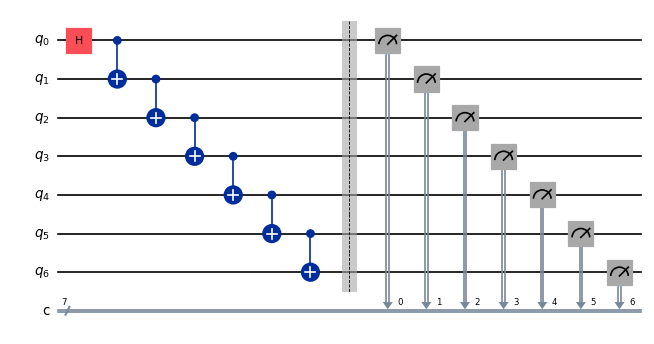

In [5]:
# Defining the GHZ state
num_qubits = 7 # size of GHZ state
qc = QuantumCircuit(num_qubits,num_qubits)
qc.h(0)
for i in range(num_qubits-1):
    qc.cx(i,i+1)
qc.barrier()
qc.measure(range(num_qubits), range(num_qubits))
qc.draw('mpl',style="iqp", scale=0.6)

In [6]:
qc.depth() # number of layers of gates applied in parallel 

8

Next, we execute the GHZ quantum circuit in the local simulator to obtain the ideal result.

In [15]:
job = execute(qc, local_simulator, shots = 4000)
results = job.result()

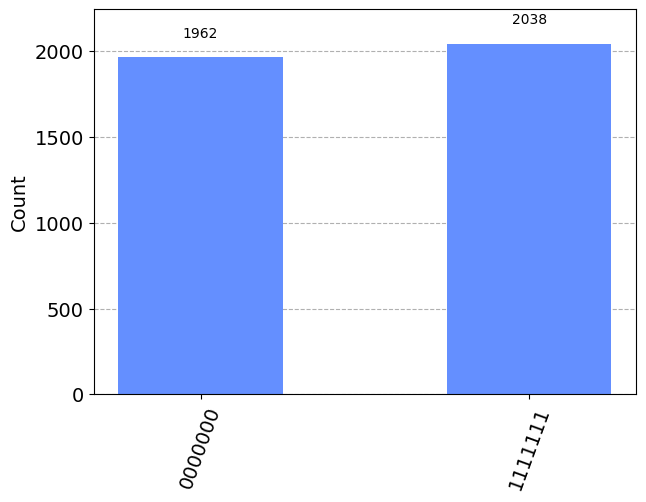

In [16]:
counts = results.get_counts()
plot_histogram(counts)

Now we will run on ibm_quebec

In [24]:
# job_qc = execute(qc, backend, shots = 4000)
# Job_id = job_qc.job_id()
# print(f'--------------------------------\nJob ID: {Job_id}\n--------------------------------')

--------------------------------
Job ID: cpr05t7sp83g008ybrx0
--------------------------------
Job not finished yet!


In [41]:
job_id = 'cpr05t7sp83g008ybrx0'
job_qc = provider.retrieve_job(job_id)

In [42]:
results_qc = job_qc.result()
counts_q = results_qc.get_counts()

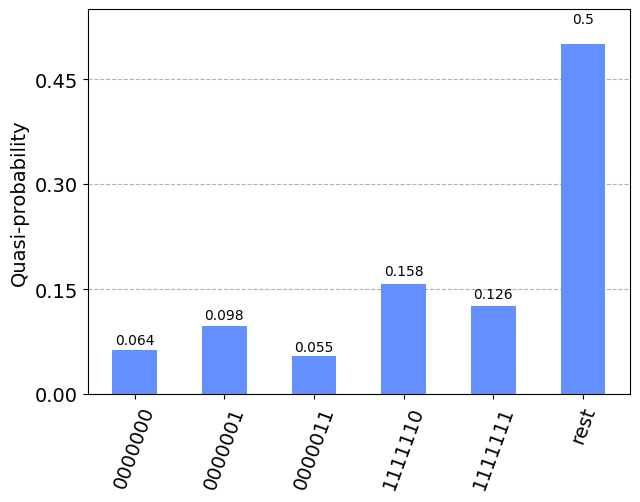

In [37]:
plot_distribution(counts_qc, number_to_keep=5)

Let's use the error supression and mitigation techniques included in the qiskit runtime to improve the results:

In [31]:
service = QiskitRuntimeService(instance="pinq-quebec-hub/ecole-dhiver/qml-workshop") #specify channel here

In [32]:
backend = service.backend('ibm_quebec')

In [33]:
options = Options(optimization_level=2, resilience_level = 1)

with Session(service=service, backend=backend) as session:
    # Submit a request to the Sampler primitive within the session.
    sampler = Sampler(session=session, options=options)
    job_qrt = sampler.run(circuits=qc)
    print(job_qrt.job_id())

cpr24wv1tcz0008mded0
Sampler results: SamplerResult(quasi_dists=[{0: 0.415257350230391, 1: 0.013641919265227, 2: -0.001496100111057, 3: 0.031235615803354, 4: 0.000882208162968, 5: 0.001282222197417, 6: 0.002499185019961, 7: 0.006702174395529, 8: -0.010566045245497, 10: 0.00034230436597, 11: -0.000907126365836, 12: 0.001076305053756, 13: -1.6775574463e-05, 14: 0.000191242274856, 15: 0.012811643707059, 16: -0.000870064819498, 27: 0.000107530548999, 28: 0.002514921404568, 29: 8.892573756e-06, 30: 0.001363703052612, 31: 0.015450120572111, 32: -0.013170517380184, 34: 4.9068388911e-05, 35: -0.000181631357842, 38: 0.000131509335259, 54: 0.000255221756611, 59: 0.000152828404985, 60: 0.000709988171534, 63: -0.000704694434413, 64: 0.001962082652198, 65: 0.001084214535077, 67: 0.000145310391211, 68: -4.0987305026e-05, 72: 0.000347518721922, 79: -0.000393958217155, 80: 0.000259919241036, 88: -0.000113606552571, 89: 0.000154021142052, 91: 6.242911962e-05, 92: -0.000941602568322, 93: -5.8490302829e-

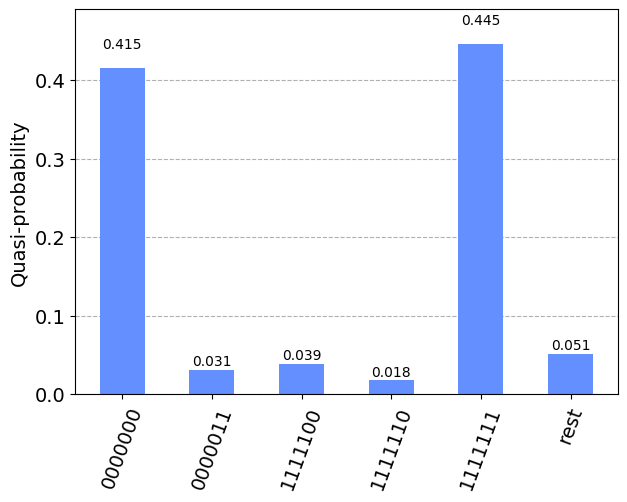

In [35]:
counts_qrt = job_qrt.result().quasi_dists[0].binary_probabilities()
plot_histogram(counts_qrt,number_to_keep=5)

## Let's compare the results

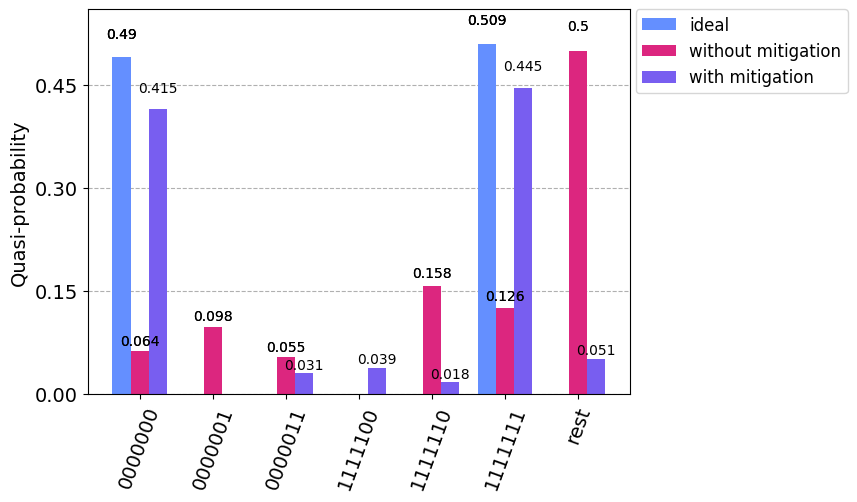

In [40]:
plot_distribution([counts,counts_qc,counts_qrt], number_to_keep=5, legend=["ideal","without mitigation", "with mitigation"])